In [ ]:
import os
import subprocess
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


1. Data Collection (Scan the Environment):
Mobile Device Sensors: The process starts with using the phone's built-in sensors, such as the camera, accelerometer, gyroscope, and depth sensors (if available like LiDAR on iPhones or depth sensors in Android phones).
Visual Data Capture: The user moves the phone around the room, capturing images or video frames while the system simultaneously collects data. In some cases, the phone may use its depth sensors to get more accurate measurements of distances between objects and the camera.
2. Feature Detection:
Keypoint Detection: The system uses computer vision algorithms (such as SIFT, ORB, or more advanced deep learning techniques) to detect keypoints (distinct features in the environment like corners, edges, and textures) in the images. This is crucial for understanding the environment and tracking the movement of the phone.
Feature Matching: The system identifies and tracks these keypoints across multiple frames or images to understand the camera’s movement relative to the environment. Essentially, the system figures out how the camera has moved between frames by matching common features between successive frames.
3. Simultaneous Localization and Mapping (SLAM):
Camera Localization: Using SLAM algorithms, the system determines the position and orientation (pose) of the phone as it moves through the room. The phone tracks its own location relative to the captured environment.
Building a Map: As the system tracks the phone's position, it creates a 3D map of the environment. This map can be a sparse 3D point cloud or a more detailed mesh of the room.
Visual SLAM (VSLAM): This type of SLAM relies on visual data (images/videos) to estimate the camera’s trajectory and environment.
LiDAR/Depth SLAM: When using LiDAR (on devices like the iPhone 12 Pro and later), the system can also use depth data to enhance the accuracy of the map, creating a denser, more precise 3D reconstruction of the space.
4. 3D Reconstruction:
Depth Estimation: Once keypoints are detected and the camera’s trajectory is known, the system uses stereo vision or depth sensors to estimate the 3D coordinates of the detected features.
Point Cloud Generation: Using the stereo matching process (or LiDAR), the system creates a point cloud—a collection of 3D points representing the surfaces of objects in the environment.
Mesh Generation: Some systems may go a step further and convert this point cloud into a polygonal mesh by triangulating the points. This process involves creating surfaces that connect the points, resulting in a 3D model with texture and geometry.
5. Refinement and Optimization:
Bundle Adjustment: To improve the accuracy of the 3D reconstruction, systems often perform a process called bundle adjustment, which optimizes the 3D model by minimizing errors in camera pose estimation and 3D point placement.
Texture Mapping: Once the 3D structure is in place, the system can project the original images onto the 3D model to add textures, providing a realistic visual appearance of the environment.
6. Post-Processing and Export:
Model Refinement: The raw 3D model might still need some refinement. Algorithms can fill gaps, smooth surfaces, and improve the overall quality of the 3D model.
Rendering: The final 3D model can be rendered in real-time using 3D graphics software. It might be displayed on the phone, used for AR experiences, or exported to formats like .obj, .fbx, or .ply for use in other 3D applications (e.g., CAD, VR, AR, or 3D printing).
7. User Interaction and Visualization:
Interactive Viewing: Once the 3D model is created, the user can view the model interactively, rotate it, zoom in/out, or even place virtual objects within the space. This might be used for visualization in AR (Augmented Reality) or VR (Virtual Reality) environments.
AR Integration: For real-time AR applications, the system can overlay the 3D model on the camera feed to let users see virtual objects placed in the real environment, making the model interactive and useful for various applications like interior design or virtual tours.
8. Cloud Processing (Optional):
In some cases, especially for apps like Matterport, the initial scan data is sent to the cloud, where the heavy computational tasks of generating 3D models and optimizing them are performed on powerful servers. The final models are then available for download or interaction through web or mobile applications.


In [ ]:
video_name = "input"
ffmpeg_path = r'C:\Program Files\FFmpeg\bin\ffmpeg.exe'

In [ ]:
# Define the path for ffmpeg
ffmpeg_path = r'C:\Program Files\FFmpeg\bin\ffmpeg.exe'

def get_input_video_path(filename):
    # get first file named filename
    files = [file for file in os.listdir() if os.path.isfile(file)]
    
    for file in files:
        if file.lower().startswith(filename):
            return file
    
        raise FileNotFoundError(f"No file starting with '{filename}' found in the directory.")

def convert_to_mp4(video_path):
    # convert filename to .mp4
    if video_path:
        if video_path.lower().endswith('.mov'):
            output_path = video_path.rsplit('.', 1)[0] + '.mp4'
            if os.path.exists(output_path):
                print(f"The file {output_path} already exists. Skipping conversion.")
                return output_path
            try:
                subprocess.run([ffmpeg_path, '-i', video_path, output_path], check=True)
                print(f"Conversion complete: {output_path}")
                return output_path
            except subprocess.CalledProcessError as e:
                print(f"Error converting video: {e}")
                return video_path
        else:
            print("The provided video is not a .mov or .MOV file.")
            return video_path
    else:
        print(f"No '{video_path}' file found in the directory.")
        return None

video_path = get_input_video_path(video_name)

try:
    video_path = get_input_video_path(video_name)
    video_path = convert_to_mp4(video_path)
except FileNotFoundError as e:
    print(f"Error: {e}")


In [ ]:
def extract_frames(video_path, output_folder, fps=10):
    # extract video frames
    if os.path.exists(output_folder) and os.listdir(output_folder):
        print(f"The folder '{output_folder}' is not empty. Skipping frame extraction.")
    else:
        os.makedirs(output_folder, exist_ok=True)
        cmd = [ffmpeg_path, "-i", video_path, "-vf", f"fps={fps}", os.path.join(output_folder, "frame_%04d.jpg")]
        subprocess.run(cmd, check=True)
        print(f"Frames saved in {output_folder}")

extract_frames(video_path, "frames", fps=10)

In [ ]:
def detect_keypoints_and_match(image1_path, image2_path):
    # Load images
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)  # First image (grayscale)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)  # Second image (grayscale)
    # Example preprocessing with histogram equalization
    img1 = cv2.equalizeHist(img1)
    img2 = cv2.equalizeHist(img2)

    # Initialize ORB detector
    orb = cv2.ORB_create(nfeatures=500,  # Increase number of keypoints (default is 500)
                         scaleFactor=1.2,  # Control the pyramid scale (lower values capture more features at smaller scales)
                         edgeThreshold=31)

    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    
    # Initialize the Brute Force Matcher with Hamming distance and cross-checking
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors between two images
    matches = bf.match(des1, des2)

    # Sort matches based on their distance (best matches first)
    matches = sorted(matches, key = lambda x: x.distance)
    print(f"Number of matches: {len(matches)}")

    # Draw the matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Show the matched keypoints
    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches)
    plt.title("Keypoint Matches")
    plt.axis('off')
    plt.show()

# Paths to the images you want to match
image1_path =  os.path.join("frames", "frame_0001.jpg")
image2_path =  os.path.join("frames", "frame_0002.jpg")

# Call the function to detect keypoints and match them
detect_keypoints_and_match(image1_path, image2_path)


In [38]:
def detect_keypoints_and_match(image1, image2):
    """
    Detects keypoints in two images and matches them using ORB and BFMatcher.
    Returns the keypoints and matches between the two images.
    """
    # Convert images to grayscale
    img1 = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        raise ValueError(f"Error loading images: {image1} or {image2}")

    # Preprocessing (Histogram equalization)
    img1 = cv2.equalizeHist(img1)
    img2 = cv2.equalizeHist(img2)

    # Initialize ORB detector
    orb = cv2.ORB_create(nfeatures=500, scaleFactor=1.2, edgeThreshold=31)

    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # If no keypoints were found, return empty lists
    if des1 is None or des2 is None:
        return kp1, kp2, []  # No matches

    # Initialize the Brute Force Matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors between the two images
    matches = bf.match(des1, des2)

    # Sort matches based on their distance (best matches first)
    matches = sorted(matches, key=lambda x: x.distance)

    return kp1, kp2, matches



def process_images_in_folder(folder_path, number_of_images=None):
    """
    Processes a folder containing images, matching consecutive pairs of images.
    Returns a dataframe with the matched keypoints and image info.
    """
    # Get the list of images in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    image_files.sort()  # Sort the images alphabetically (you can adjust this depending on your needs)

    # If number_of_images is not specified, use all the images in the folder
    if number_of_images is None:
        number_of_images = len(image_files)

    # Initialize an empty dataframe to store the keypoint matches
    columns = ['point_id'] + image_files[:number_of_images]
    df = pd.DataFrame(columns=columns)

    point_id = 1  # Start point ids from 1

    # Iterate through the images
    for i in range(number_of_images - 1):
        img1 = image_files[i]
        img2 = image_files[i + 1]

        # Get keypoints and matches between consecutive images
        kp1, kp2, matches = detect_keypoints_and_match(os.path.join(folder_path, img1), os.path.join(folder_path, img2))

        # Add new rows to the dataframe
        for match in matches:
            # Get the keypoint coordinates in both images
            point1 = [kp1[match.queryIdx].pt[0], kp1[match.queryIdx].pt[1]]
            point2 = [kp2[match.trainIdx].pt[0], kp2[match.trainIdx].pt[1]]

            # Check if the point_id already exists in the dataframe, if not, create a new row
            if point_id not in df['point_id'].values:
                new_row = {col: [] for col in df.columns}
                new_row['point_id'] = point_id
                new_row[img1] = point1
                new_row[img2] = point2
                df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
                point_id += 1
            else:
                # Update the existing point entry with the new match
                df.loc[df['point_id'] == point_id, img1] = point1
                df.loc[df['point_id'] == point_id, img2] = point2

    return df

folder_path = "frames"  # Replace with your folder path

# Process images in the folder and generate the dataframe
df = process_images_in_folder(folder_path, number_of_images=3)  # Example: process 5 images
print(df)


    point_id                            frame_0001.jpg  \
0          1        [432.9677734375, 1326.27490234375]   
1          2  [157.24801635742188, 1698.6241455078125]   
2          3   [580.6080932617188, 1511.6546630859375]   
3          4    [695.1372680664062, 394.1499938964844]   
4          5    [569.7258911132812, 759.6345825195312]   
..       ...                                       ...   
722      723                                        []   
723      724                                        []   
724      725                                        []   
725      726                                        []   
726      727                                        []   

                              frame_0002.jpg  \
0    [440.4327392578125, 1323.7864990234375]   
1    [164.16001892089844, 1695.168212890625]   
2        [586.828857421875, 1509.5810546875]   
3     [702.3036499023438, 394.1499938964844]   
4     [576.8922729492188, 759.6345825195312]   
..             

6


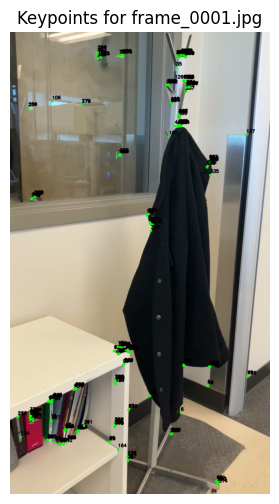

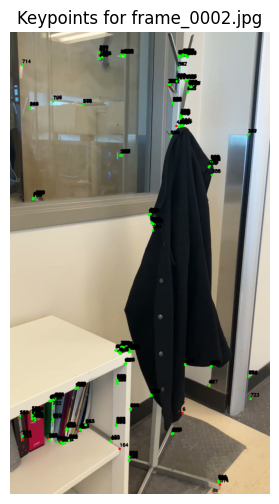

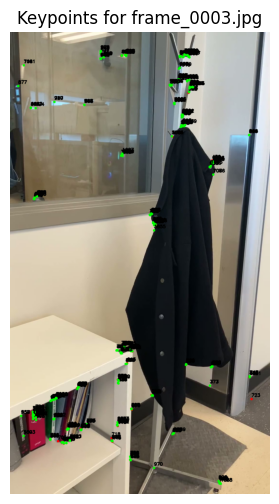

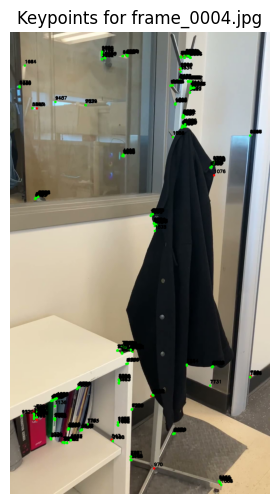

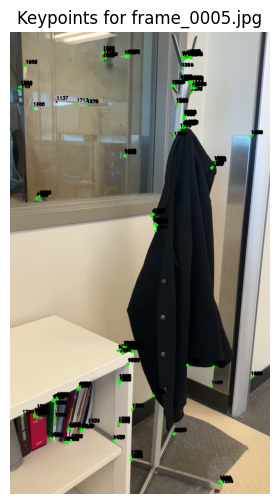

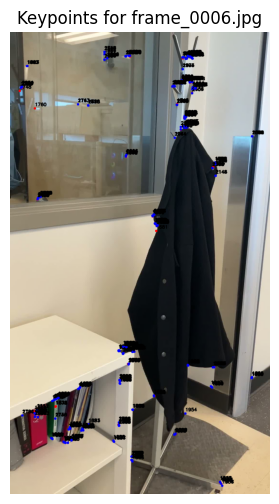

In [37]:
def visualize_keypoints_and_matches(folder_path, df, number_of_images=None):
    """
    Visualize keypoints across all images, highlighting points that exist in adjacent images.
    """
    # Load the images from the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    image_files.sort()

    if number_of_images is None:
        number_of_images = len(image_files)

    print(number_of_images)

    # Iterate through the images and visualize keypoints
    for i in range(number_of_images):
        img_path = os.path.join(folder_path, image_files[i])
        img = cv2.imread(img_path)

        # Plot points for each keypoint in the dataframe
        for _, row in df.iterrows():
            point_id = row['point_id']
            point = row[image_files[i]]

            if isinstance(point, list) and len(point) == 2:  # Ensure point exists and has x, y coordinates
                x, y = point

                # Find the point's status (red, blue, purple, or error)
                prev_img = image_files[i - 1] if i > 0 else None
                next_img = image_files[i + 1] if i < number_of_images - 1 else None

                if prev_img and isinstance(row[prev_img], list) and len(row[prev_img]) == 2:
                    color = (0, 0, 255)  # Red for previous
                elif next_img and isinstance(row[next_img], list) and len(row[next_img]) == 2:
                    color = (0, 255, 0)  # green
                    for next
                else:
                    color = (255, 0, 0)  # Blue for current

                # Draw the point on the image
                img = cv2.circle(img, (int(x), int(y)), 5, color, -1)

                # Add point_id above the point
                font = cv2.FONT_HERSHEY_SIMPLEX
                img = cv2.putText(img, str(point_id), (int(x), int(y) - 10), font, 0.6, (0, 0, 0), 2, cv2.LINE_AA)
            else:
                # Skip if the point does not exist
                continue

        # Show the image with keypoints
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Keypoints for {image_files[i]}")
        plt.axis('off')
        plt.show()

visualize_keypoints_and_matches(folder_path, df, number_of_images=6)

In [3]:
import cv2
import numpy as np

# Load a video (or sequence of images)
cap = cv2.VideoCapture("input.mp4")  # Change to image sequence if needed

# Parameters for feature detection
feature_params = dict(maxCorners=200, qualityLevel=0.3, minDistance=7, blockSize=7)

# Parameters for Lucas-Kanade Optical Flow
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Read the first frame and detect feature points
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

# Create a mask for visualization
mask = np.zeros_like(old_frame)

while True:
    # Read next frame
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate Optical Flow (track points)
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # Draw tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

    # Overlay mask on frame
    img = cv2.add(frame, mask)

    # Show result
    cv2.imshow("Optical Flow Tracking", img)

    # Update previous frame and points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

    # Exit on ESC key
    if cv2.waitKey(30) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()
